In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import copy
from sklearn.cluster import KMeans

In [14]:
# HELPER FUNCTIONS

"""
Encode categorical variables and fill missing values with 0
"""
def encode_and_fill(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)

    ordinal_encoder = OrdinalEncoder()
    label_df = df.copy()
    label_df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

    label_df = label_df.fillna(0)

    return label_df

"""
Replace groups of highly correlated features with their average values
"""
def avg_features(df):
    Xtraindf = copy.deepcopy(df)
    Xtraindf['Avg_min_temp_winter'] = (Xtraindf['january_min_temp'] + Xtraindf['february_min_temp'] + Xtraindf['march_min_temp'] + Xtraindf['april_min_temp'] + Xtraindf['october_min_temp'] + Xtraindf['november_min_temp'] + Xtraindf['december_min_temp'])/7
    Xtraindf['Avg_max_temp_winter'] = (Xtraindf['january_max_temp'] + Xtraindf['february_max_temp'] + Xtraindf['march_max_temp'] + Xtraindf['april_max_temp'] + Xtraindf['october_max_temp'] + Xtraindf['november_max_temp'] + Xtraindf['december_max_temp'])/7
    Xtraindf['Avg_temp_winter'] = (Xtraindf['january_avg_temp'] + Xtraindf['february_avg_temp'] + Xtraindf['march_avg_temp'] + Xtraindf['april_avg_temp'] + Xtraindf['october_avg_temp'] + Xtraindf['november_avg_temp'] + Xtraindf['december_avg_temp'])/7
    Xtraindf['Avg_min_temp_summer'] = (Xtraindf['may_min_temp'] + Xtraindf['june_min_temp'] + Xtraindf['july_min_temp'] + Xtraindf['august_min_temp'] + Xtraindf['september_min_temp'])/5 
    Xtraindf['Avg_max_temp_summer'] = (Xtraindf['may_max_temp'] + Xtraindf['june_max_temp'] + Xtraindf['july_max_temp'] + Xtraindf['august_max_temp'] + Xtraindf['september_max_temp'])/5
    Xtraindf['Avg_temp_summer'] = (Xtraindf['may_avg_temp'] + Xtraindf['june_avg_temp'] + Xtraindf['july_avg_temp'] + Xtraindf['august_avg_temp'] + Xtraindf['september_avg_temp'])/5 
    Xtraindf['Avg_days_below30F'] = (Xtraindf['days_below_30F'] + Xtraindf['days_below_20F'] + Xtraindf['days_below_10F'] + Xtraindf['days_below_0F'])/4
    return Xtraindf

"""
Create an k-means inertia plot for the given data
"""
def plot_inertia(X):
    # Inertia plots
    inertia = []
    for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
        model = KMeans(n_clusters = i)
        model.fit(X)
        inertia.append(model.inertia_)
    plt.plot(range(2,16), inertia)
    plt.title('Inertia Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show() 

"""
Perform k-means clustering on given data and add cluster labels to the DataFrame.
Return the fitted k-means model and the DataFrame wtih cluster labels.

Note: df must be the full DataFrame without the target value removed.
"""
def k_means(k, df):
    cluster_df = copy.deepcopy(df) # For adding cluster labels
    X_df = copy.deepcopy(df) # Features for training kmeans
    X_df = X_df.drop(columns=['site_eui', 'id'])

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_df)
    y_predict = kmeans.fit_predict(X_df)
    cluster_df['cluster'] = y_predict
    return kmeans, cluster_df

"""
Run RandomForest on each cluster of the dataset. Return a list of scores.
Note: df must be the full DataFrame including target values and a 'cluster' feature.
"""
def rf_cluster(df, num_clusters):
    rf_scores = [] # List of random forest scores

    # Run random forest on each cluster
    for i in range(num_clusters):
        # Isolate current cluster
        cluster_df = df.loc[df['cluster'] == i]
        y = np.array(cluster_df['site_eui']).reshape(-1,1)
        X = cluster_df.drop(columns=['site_eui', 'id', 'cluster'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        # Run random forest
        rf = RandomForestRegressor(n_estimators=40, max_depth=8)
        rf.fit(X_train, y_train.ravel())
        y_pred = rf.predict(X_test)
        score = rf.score(X_test, y_test)
        rf_scores.append(score)

    return rf_scores


In [12]:
### SPLIT DATA BASED ON BUILDING TYPE ###

train_df = pd.read_csv('train.csv')

# Separate data for commercial and residential buildings
com_train_df = train_df.loc[train_df['building_class'] == 'Commercial']
res_train_df = train_df.loc[train_df['building_class'] == 'Residential']
com_train_df = com_train_df.drop(columns=['building_class'])
res_train_df = res_train_df.drop(columns=['building_class'])

# Encode and fill, avg features
com_train_df = encode_and_fill(com_train_df)
com_train_df = avg_features(com_train_df)
res_train_df = encode_and_fill(res_train_df)
res_train_df = avg_features(res_train_df)

y_com_train = np.array(com_train_df['site_eui']).reshape(-1,1)
X_com_train = com_train_df.drop(columns=['site_eui', 'id'])
y_res_train = np.array(res_train_df['site_eui']).reshape(-1,1)
X_res_train = res_train_df.drop(columns=['site_eui', 'id'])



/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

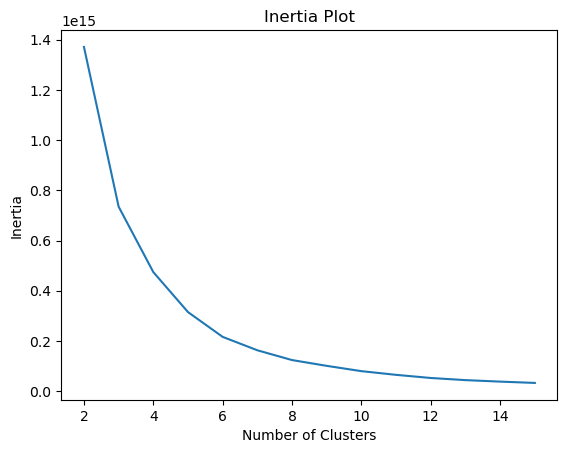

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

RF scores with 2 clusters:
[0.36367704816311164, 0.6195820200654649]

RF scores with 3 clusters:
[0.4511547225608765, 0.5356955087058242, 0.5232659923510645]

RF scores with 4 clusters:
[0.35019322183788537, 0.6731122774570273, 0.5697622669388457, 0.6705945593574525]

RF scores with 5 clusters:
[0.3785537661905972, 0.7300746074561497, 0.31950385181678753, 0.5543421725108386, 0.7311046904530022]

RF scores with 6 clusters:
[0.35273669523733453, 0.6694073129447335, 0.6891682874888576, 0.4920414361215053, -0.8770697047362774, 0.5401653956308526]

RF scores with 7 clusters:
[0.35987141418337953, 0.7145113956460389, 0.6040299510006772, 0.4677782834754354, 0.47967688806299824, 0.11902069492704437, 0.534756082996175]

RF scores with 8 clusters:
[0.366598523638084, 0.5490033629601271, 0.38077292270401497, 0.45127992759591307, 0.5236314871085304, 0.6271780599294434, 0.47242677571282377, 0.7715699534128715]



In [17]:
### KMEANS FOR COMMERCIAL ###

plot_inertia(X_com_train)

# Dictionary with num_clusters as keys and rf_score lists as values
rf_scores_com = dict()

# Run kmeans and random forest
for k in range(2,9):
    kmeans_model, com_df_clus = k_means(k,com_train_df)
    rf_scores = rf_cluster(com_df_clus,k)
    rf_scores_com[k] = rf_scores

for k in rf_scores_com.keys():
    print("RF scores with", k, "clusters:")
    print(rf_scores_com[k])
    print()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

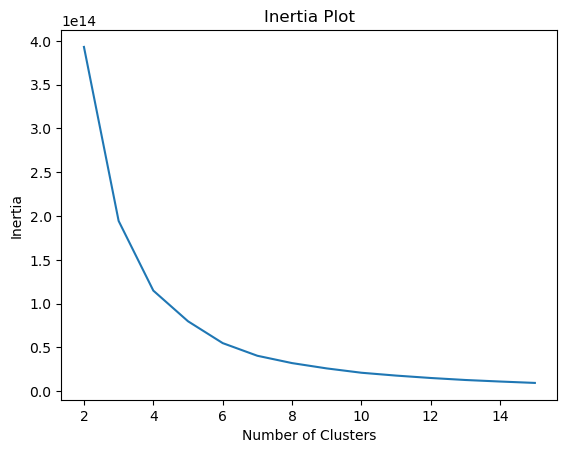

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

RF scores with 2 clusters:
[0.4410658796058745, 0.6664752025830929]

RF scores with 3 clusters:
[0.38479441628223976, 0.6382153516123983, 0.6142678373703003]

RF scores with 4 clusters:
[0.40215219905545385, 0.6208861305323201, 0.6947833154582719, 0.27014091153566533]

RF scores with 5 clusters:
[0.3845797108049518, 0.5554811683115338, 0.505700917050196, 0.6060272052554403, 0.497638707394197]

RF scores with 6 clusters:
[0.3768885401597265, 0.5223958071223576, 0.664734541417666, 0.592987806398724, 0.5544357239757522, 0.4817676743748748]

RF scores with 7 clusters:
[0.399844828528917, 0.7861902833706444, 0.6202554706097796, 0.7383683618675476, 0.4957589917033439, 0.3731856947256422, 0.5660316665302867]

RF scores with 8 clusters:
[0.37603413874162006, 0.6090895007552524, 0.7896380052396758, 0.3796349503292037, -0.1953369655470647, 0.7212910799126825, 0.5218081970008516, 0.6885363814039305]



In [18]:
### KMEANS FOR RESIDENTIAL ###

plot_inertia(X_res_train)

# Dictionary with num_clusters as keys and rf_score lists as values
rf_scores_res = dict()

# Run kmeans and random forest
for k in range(2,9):
    kmeans_model, com_df_clus = k_means(k,com_train_df)
    rf_scores = rf_cluster(com_df_clus,k)
    rf_scores_res[k] = rf_scores

for k in rf_scores_res.keys():
    print("RF scores with", k, "clusters:")
    print(rf_scores_res[k])
    print()